In [1]:
import matplotlib.pyplot as plt
import nltk
import numpy as np
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from nltk.corpus import stopwords
from scipy import stats
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from wordcloud import WordCloud
from src.misc import import_data

np.random.seed(0)

nltk.download("stopwords")

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/tadejkrivec/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
N_CLUSTERS = 36
TSNE_COMPONENTS = 2
PLOT_SUBSET = 4
DATASET_FILE = "./data/dev-v2.0.json"
PRECALCULATED_EMBEDDINGS_FILE = "./data/dev-v2.0-precalculated.csv"
FIGURES_FOLDER = "./figures"

In [3]:
data, embeddings = import_data(
    file=DATASET_FILE, precalculated_file=PRECALCULATED_EMBEDDINGS_FILE
)

In [4]:
# t-SNE manifold projection
scaler = StandardScaler()
scaler.fit(embeddings)
embeddings = scaler.transform(embeddings)

tsne = TSNE(
    n_components=TSNE_COMPONENTS,
    perplexity=15,
    random_state=42,
    init="random",
    learning_rate=200,
)
vis_dims = tsne.fit_transform(embeddings)
vis_dims = vis_dims.astype(np.float64)

In [5]:
# k-means in projected manifold
vis_dims = vis_dims.astype(np.float64)
kmeans = KMeans(n_clusters=N_CLUSTERS, n_init=N_CLUSTERS)
kmeans.fit(vis_dims)
clusters = kmeans.predict(vis_dims)
data["cluster"] = clusters

In [6]:
data_plot = data[["questions", "cluster"]]
data_plot.loc[:, ["x"]], data_plot.loc[:, ["y"]] = vis_dims[:, 0], vis_dims[:, 1]

fig = px.scatter(
    data_plot,
    x="x",
    y="y",
    color="cluster",
    hover_data=["questions"],
    width=1000,
    height=900,
    color_continuous_scale=px.colors.qualitative.Vivid,
)
fig.update_traces(mode="markers", showlegend=False)
fig.update_coloraxes(showscale=False)
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.update_layout(
    xaxis_showticklabels=False,
    xaxis_title="",
    yaxis_showticklabels=False,
    yaxis_title="",
    plot_bgcolor="rgba(0, 0, 0, 0)",
    paper_bgcolor="rgba(0, 0, 0, 0)",
    margin=dict(l=0, r=0, t=0, b=0),
)
fig.show()

fig.write_html(f"{FIGURES_FOLDER}/clusters.html")
fig.write_image(f"{FIGURES_FOLDER}/clusters.png")

In [7]:
fig = make_subplots(rows=2, cols=2)

for idx, title in enumerate(np.unique(data["title"].values)[:PLOT_SUBSET]):
    row = int(idx / 2)
    col = idx % 2
    fig.add_trace(
        go.Histogram(
            x=data.loc[data["title"] == title, "cluster"], name=title.replace("_", " ")
        ),
        row=row + 1,
        col=col + 1,
    )


fig.update_layout(
    plot_bgcolor="rgba(0, 0, 0, 0)",
    paper_bgcolor="rgba(0, 0, 0, 0)",
    margin=dict(l=0, r=0, t=0, b=0),
    height=1000,
    width=1200,
)
fig.update_coloraxes(showscale=False)
fig.update_xaxes(showgrid=False, showticklabels=False)
fig.update_yaxes(showgrid=False, showticklabels=False)
fig.show()

fig.write_html(f"{FIGURES_FOLDER}/histograms.html")
fig.write_image(f"{FIGURES_FOLDER}/histograms.png")

/var/folders/w9/gbx8xsps7t1g6ld_fwy759xh0000gn/T/ipykernel_38288/3705992316.py:1: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



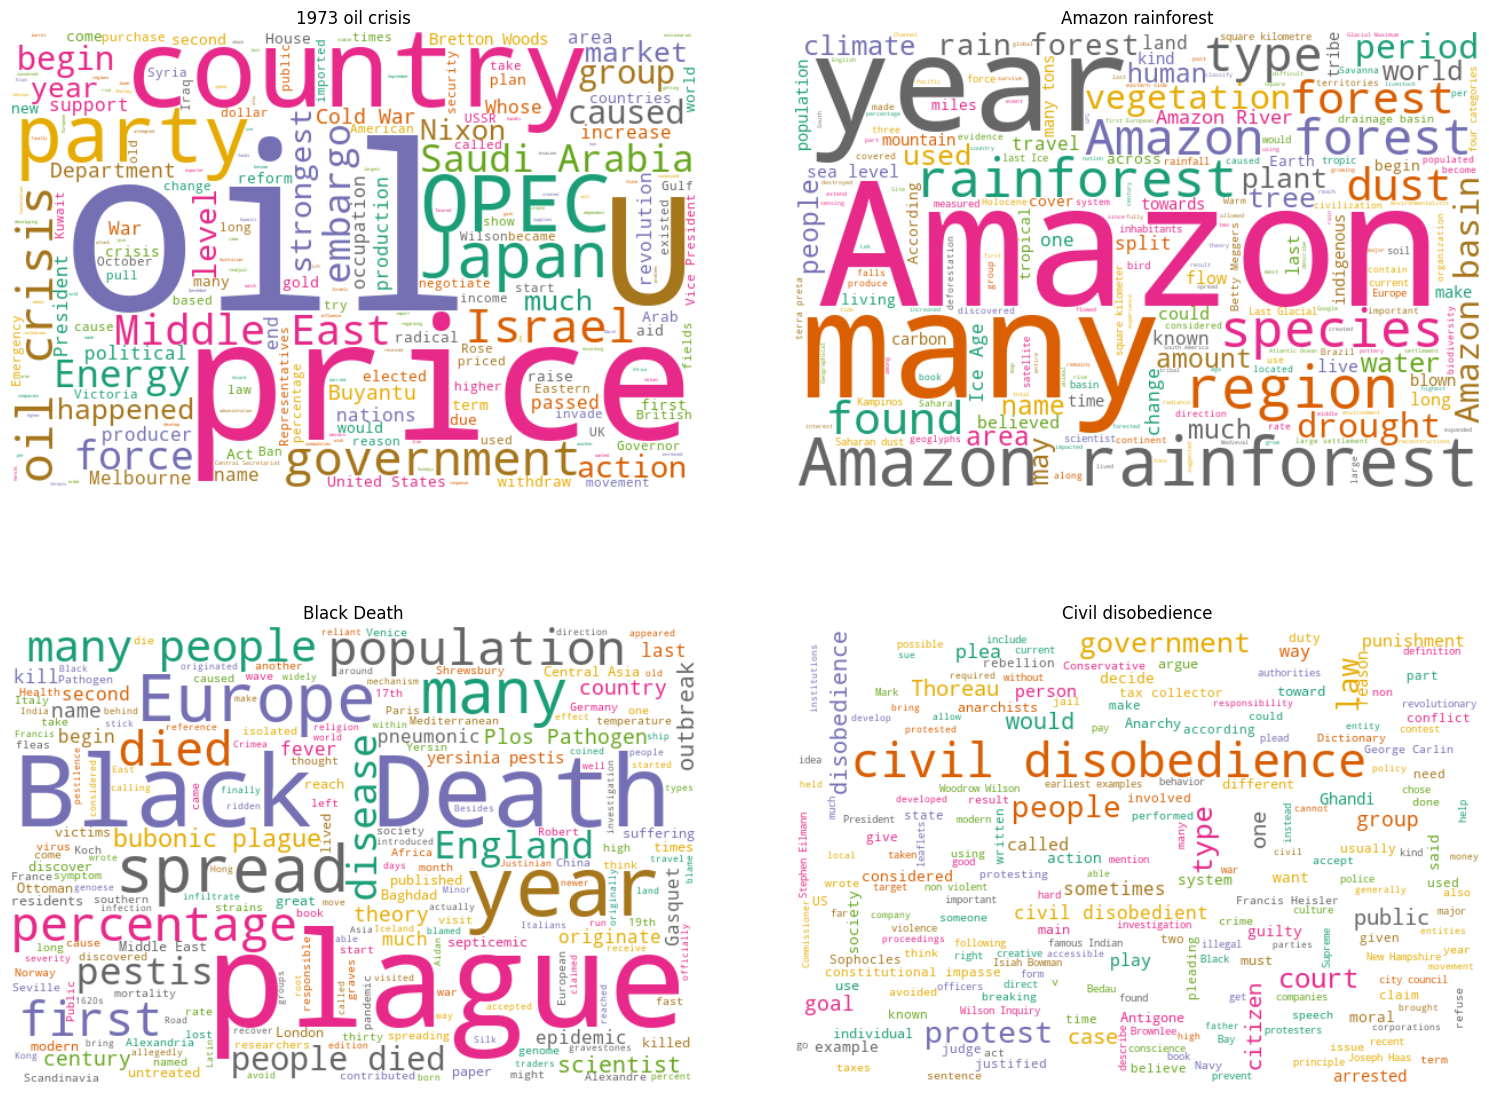

In [8]:
title_to_cluster_mapper = data.groupby("title").apply(
    lambda x: stats.mode(x["cluster"].values)[0]
)

fig, axes = plt.subplots(2, 2, figsize=(15, 13))
for idx, title in enumerate(np.unique(data["title"].values)[:PLOT_SUBSET]):
    row = int(idx / 2)
    column = idx % 2
    cluster = title_to_cluster_mapper[title]

    wc = WordCloud(
        width=600,
        height=400,
        stopwords=stopwords.words("english"),
        background_color="white",
        colormap="Dark2",
    )
    wc.generate(", ".join(data[data.cluster == cluster]["questions"].values.tolist()))

    axes[row, column].axis("off")
    axes[row, column].imshow(wc, interpolation="bilinear")
    axes[row, column].set_title(f"{title}".replace("_", " "))

fig.tight_layout(h_pad=0.0, w_pad=7.0)

fig.savefig(f"{FIGURES_FOLDER}/wouldclouds.png", transparent=True)